In [1]:
import glob
import itertools
import numpy as np
import os
import pandas as pd
import pybedtools as pbt
import statsmodels
import subprocess
import sys
import time

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
import config_readwrite as crw
import fet
import split_filename
import plot_params as pp


import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns

pp.fonts()

In [3]:
name = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configfile_name = crw.read_config(name)

BKGD = config["BKGD"]["merged_sharedacc_0000"]  # background to shuffle in
REGIONS_PATH = config["CIS_TRANS"]["regions_dir"]

RE = config["EQTL"]["results"]
FC_PY = config['VAR_ENRICHMENT']["bin"]  # script to calculate fold-change
FC_SLURM = config['VAR_ENRICHMENT']["bin_slurm"]  # script to calculate fold-change

# functions

In [4]:
def format_df(df):
    """
    return df w/ formatted columns
        Log2 OR
        Log2 CI
    """
    df["FC_log2"] = np.log2(df["FoldChange"])
    df["ci_025_log2"] = np.log2(df["ci_025"])
    df["ci_975_log2"] = np.log2(df["ci_975"])
    
    return df

In [5]:
def plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title):
    fig, ax = plt.subplots(figsize=(6,6))
    
    # get difference between y and upper/lower CI for plotting. 
    l = np.array(data[y]-data[ci_lower])
    u = np.array(data[ci_upper]- data[y])
             
    yerr = [l, u]

    sns.barplot(
            x=x, y=y, data=data,
            #hue = hue,
            linewidth=2.5, 
            #order = order,
            #facecolor=(1, 1, 1, 0),
            edgecolor=".2",
            yerr=yerr
            )
   
    plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero

    ax.set_xlabel("")

    # set the y ticks
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
    ax.yaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
    ax.set(
        xlabel = "",
        ylabel="Odds ratio, log2-scaled",  # y label
        title = title,
        ylim=ylim)
    return fig, ax

In [6]:
def annotate_bar(graph, ax, annot, height):

    if ax == "x":
    
        for p, a in zip(graph.patches, annot):

            graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

## order to plot data

In [7]:
# dictionary for sorting terms by activity category
def order_activity(df):
    cross_walk = {
                'conserved_active.regions':1,
                'cis_only':2,
                'HH-active_MM-inactive_cis+trans':3,
                'HH-active_MM-inactive_cis-only':2,
                'HH-active_MM-inactive_trans-only':4,

                'MM-active_HH-inactive_cis+trans':3,
                'MM-active_HH-inactive_cis-only':2,
                'MM-active_HH-inactive_trans-only':4,
                'cis+trans':3,
                'trans_only':4
                }

    df["order"] = ""
    for k, v in cross_walk.items():
        df.loc[df["sid"] == k, "order"]=v
        
    return df

In [8]:
def add_asterisks(df):
    df["*"]= ""
    df.loc[df["p-value"]<0.05, "*"]="*"
    return df

# analyze by tissue-eQTL set 

In [9]:
fs = glob.glob(os.path.join(RE, "*.tsv"))

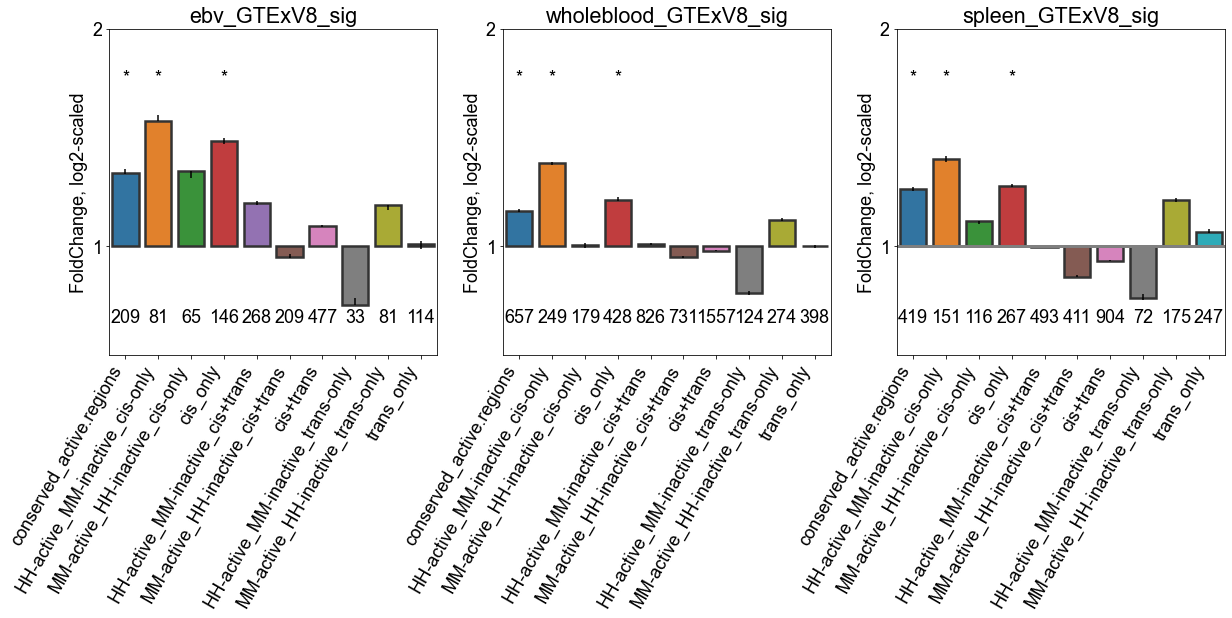

In [10]:
fig, ax_ = plt.subplots(ncols = len(fs), figsize=(20,6))

for n, f in enumerate(fs):
    ax = ax_[n]

    df = pd.read_csv(f, sep ='\t')
    df = format_df(df)
    df = order_activity(df)
    df = add_asterisks(df)
    
    # plot

    x = "sid"
    y = "FC_log2"
    data = df.sort_values(by=["order", "sid"])
    
    ci_upper, ci_lower = "ci_025_log2", "ci_975_log2"
    ytick_multiple = 1
    
    ylim =(-0.5,1) # log2 coordinates
    
    tissue = data.iloc[0]["target"]
    title = f"{tissue}"
    hue = None


    # get difference between y and upper/lower CI for plotting. 
    l = np.array(data[y]-data[ci_lower])
    u = np.array(data[ci_upper]- data[y])

    yerr = [l, u]

    sns.barplot(
            x=x, y=y, data=data,
            #hue = hue,
            linewidth=2.5, 
            #order = order,
            #facecolor=(1, 1, 1, 0),
            edgecolor=".2",
            yerr=yerr, ax=ax
            )

    plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero


    #ax.set_xticklabels(["Complex\nEnhancer", "Simple\nEnhancer", "Complex\nEnhancer\nCore v. Derived"])

    ax.set_xlabel("")

    #ax.get_yaxis().ticker.LogLocator(base=2)

    # set the y ticks
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
    ax.yaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
    ax.set(
        xlabel = "",
        ylabel="FoldChange, log2-scaled",  # y label
        title = title,
        ylim=ylim
    )
    #fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title)

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")

    annotate_bar(ax, "x", list(data['Observed']), -0.35)
    annotate_bar(ax, "x", list(data['*']), 0.75)
    #annotate_bar(ax, "x", list(data["frac"].round(2).apply(lambda x: str(x*100).split(".")[0]+ "%")), -0.2)
out = os.path.join(RE, f"EBV_spleen_wb_eQTL_V8.pdf")
plt.savefig(out, bbox_inches ="tight")

In [15]:
groups = {
    "all":[ "cis_only", "trans_only", "cis+trans","conserved_active.regions"],
    "fig":["cis_only", "trans_only", "cis+trans" ],
    "HH":['HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only', 'HH-active_MM-inactive_cis+trans' ],
    "MM":['MM-active_HH-inactive_cis-only', 'MM-active_HH-inactive_trans-only', 'MM-active_HH-inactive_cis+trans'],
}

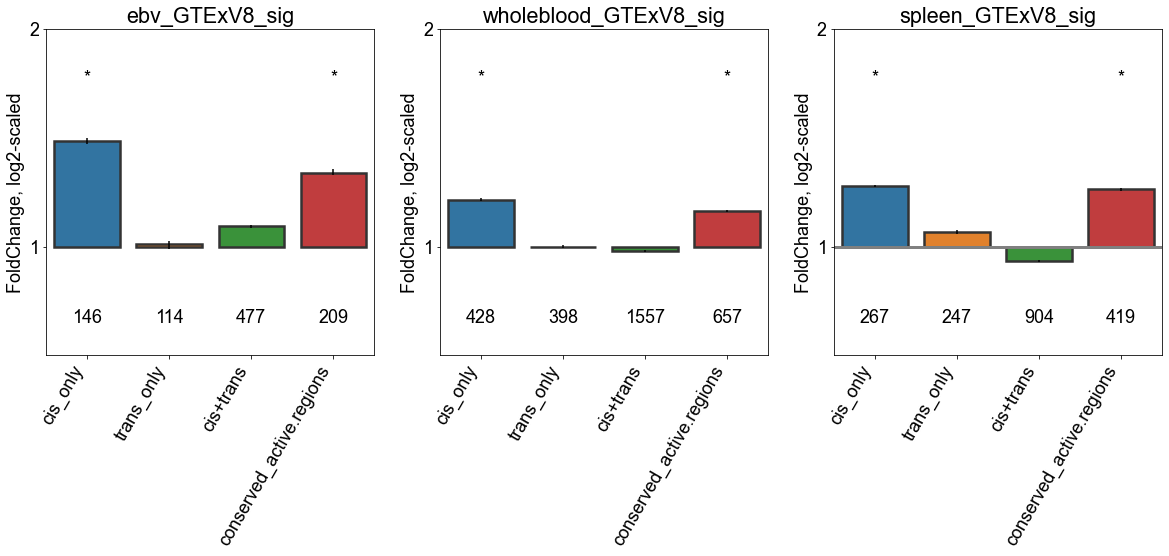

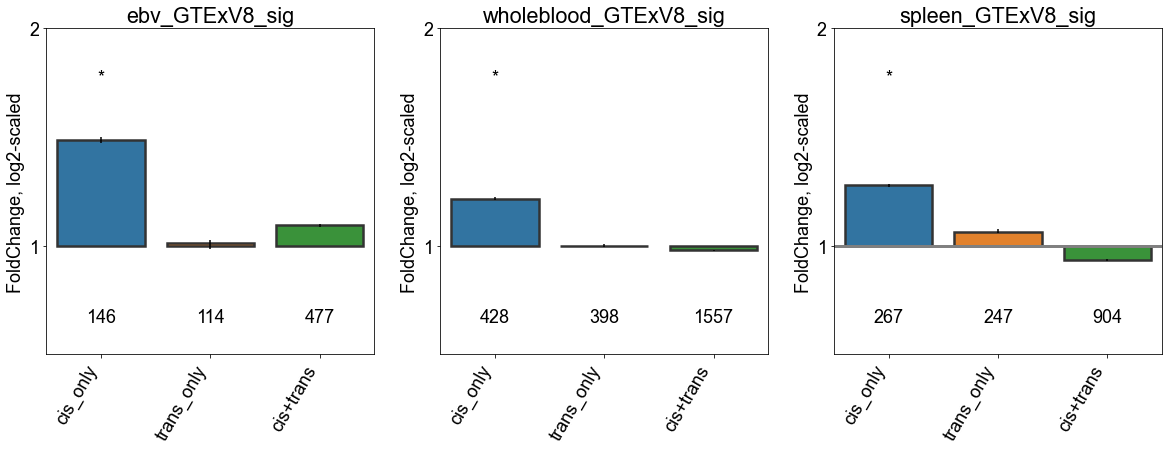

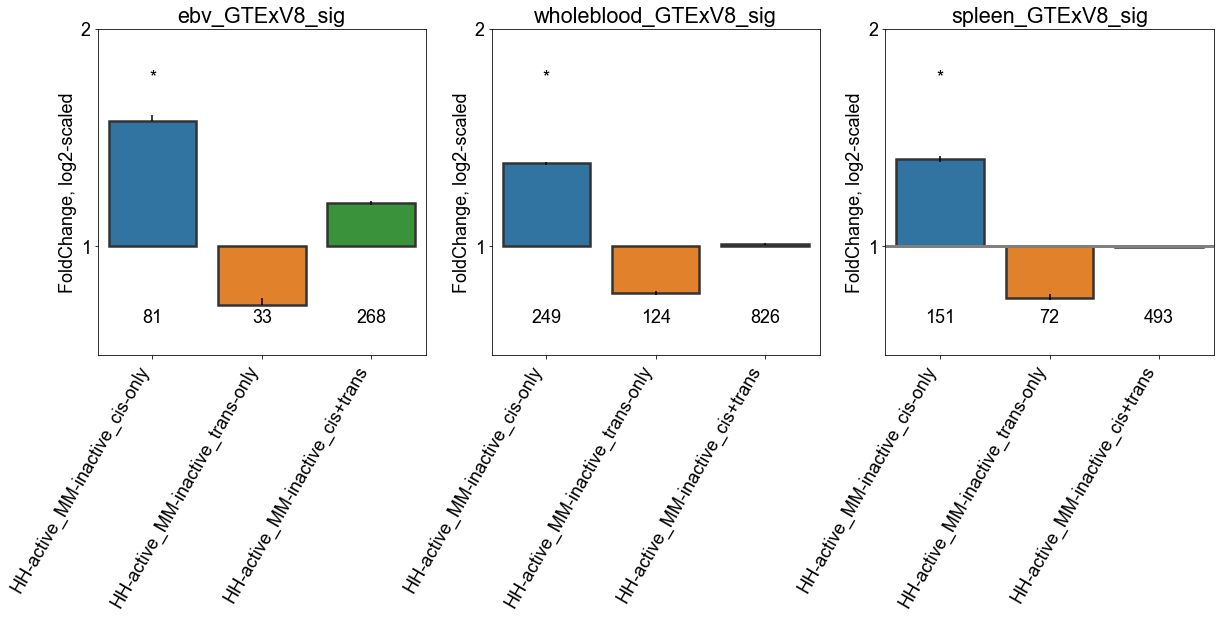

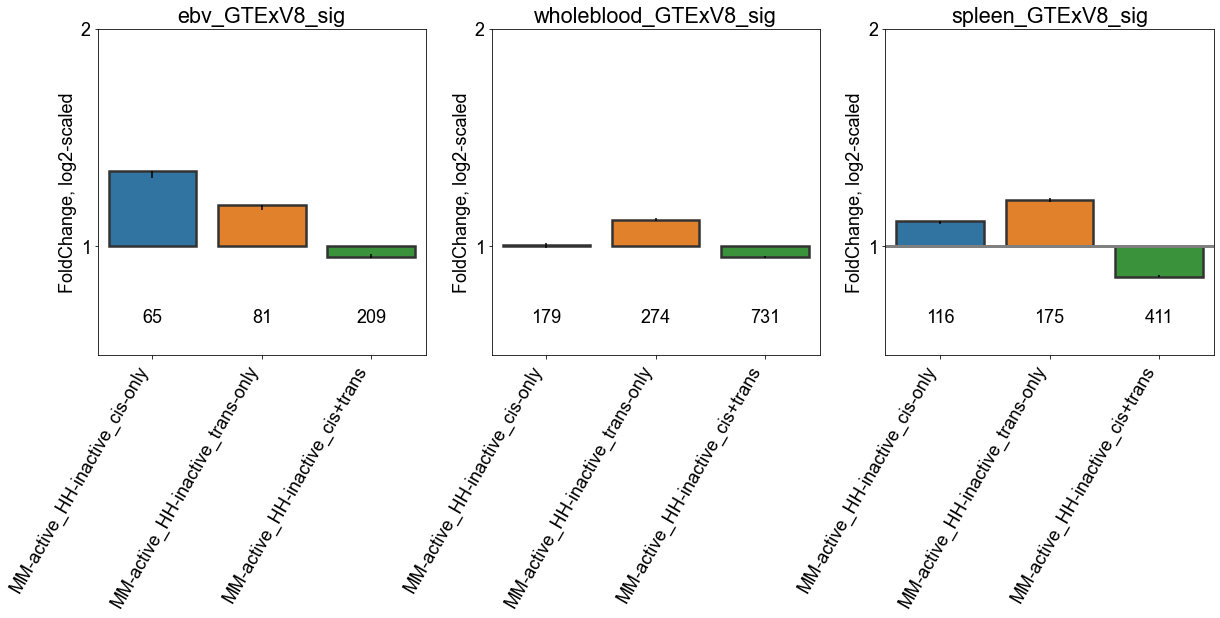

In [19]:
res = {}
val=0
for name, sids in groups.items():
    fig, ax_ = plt.subplots(ncols = len(fs), figsize=(20,6))
    for n, f in enumerate(fs):
        ax = ax_[n]

        df = pd.read_csv(f, sep ='\t')
        df = format_df(df)
        df = order_activity(df)
        df = add_asterisks(df)
        df =  df.loc[df["sid"].isin(sids)]
        res[val]=df
        val+=1
        # plot

        x = "sid"
        y = "FC_log2"
        data =df.set_index("sid")
        data = data.loc[sids].reset_index()

        ci_upper, ci_lower = "ci_025_log2", "ci_975_log2"
        ytick_multiple = 1

        ylim =(-0.5,1) # log2 coordinates

        tissue = data.iloc[0]["target"]
        title = f"{tissue}"
        hue = None


        # get difference between y and upper/lower CI for plotting. 
        l = np.array(data[y]-data[ci_lower])
        u = np.array(data[ci_upper]- data[y])

        yerr = [l, u]

        sns.barplot(
                x=x, y=y, data=data,
                #hue = hue,
                linewidth=2.5, 
                #order = order,
                #facecolor=(1, 1, 1, 0),
                edgecolor=".2",
                yerr=yerr, ax=ax
                )

        plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero


        #ax.set_xticklabels(["Complex\nEnhancer", "Simple\nEnhancer", "Complex\nEnhancer\nCore v. Derived"])

        ax.set_xlabel("")

        #ax.get_yaxis().ticker.LogLocator(base=2)

        # set the y ticks
        ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
        ax.yaxis.set_major_formatter(ticks)
        ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
        ax.set(
            xlabel = "",
            ylabel="FoldChange, log2-scaled",  # y label
            title = title,
            ylim=ylim
        )
        #fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title)

        ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")

        annotate_bar(ax, "x", list(data['Observed']), -0.35)
        annotate_bar(ax, "x", list(data['*']), 0.75)
        #annotate_bar(ax, "x", list(data["frac"].round(2).apply(lambda x: str(x*100).split(".")[0]+ "%")), -0.2)
    out = os.path.join(RE, f"{name}_eQTL_V8_fig.pdf")
    plt.savefig(out, bbox_inches ="tight")

In [22]:
resdf = pd.concat(res.values()).drop_duplicates()

In [23]:
resdf.head()

,Observed,Expected,StdDev,FoldChange,p-value,date_time,ci_975,ci_025,iters,sid,target,ntotalvars_in_target,FC_log2,ci_025_log2,ci_975_log2,order,*
0,114,113.0,12.222342,1.008772,0.969031,2022-07-11 21:08:15.489197,0.990758,1.017544,1000,trans_only,ebv_GTExV8_sig,303396,0.012600,0.025091,-0.013395,4,
1,209,165.0,15.718827,1.265060,0.007992,2022-07-11 21:08:15.875473,1.257393,1.280120,1000,conserved_active.regions,ebv_GTExV8_sig,303396,0.339206,0.356280,0.330436,1,*
8,477,447.0,23.574444,1.066964,0.210789,2022-07-11 21:09:02.993430,1.062180,1.071706,1000,cis+trans,ebv_GTExV8_sig,303396,0.093512,0.099910,0.087028,3,
9,146,104.0,11.946678,1.400000,0.001998,2022-07-11 21:09:17.654536,1.386538,1.413208,1000,cis_only,ebv_GTExV8_sig,303396,0.485427,0.498973,0.471488,2,*
0,398,398.0,23.375712,1.000000,1.000000,2022-07-11 21:14:40.494755,0.994962,1.004988,1000,trans_only,wholeblood_GTExV8_sig,1203342,0.000000,0.007178,-0.007286,4,


In [29]:
table=resdf.pivot(index="sid", columns = "target", values="FC_log2")
ptable=resdf.pivot(index="sid", columns = "target", values="*")

In [35]:
reindex = [
    'conserved_active.regions',
    'cis_only',
    'trans_only',
    'cis+trans',


    'HH-active_MM-inactive_cis-only',
    'HH-active_MM-inactive_trans-only',
    'HH-active_MM-inactive_cis+trans',

    'MM-active_HH-inactive_cis-only',
    'MM-active_HH-inactive_trans-only',
    'MM-active_HH-inactive_cis+trans',
    ]
table=table.loc[reindex]
ptable=ptable.loc[reindex]

#ptable=ptable.round(2)

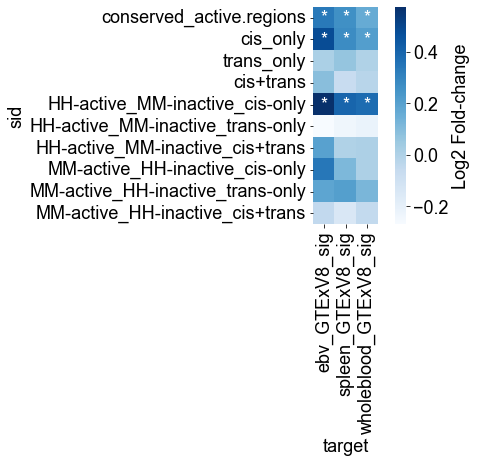

In [37]:
sns.heatmap(table, square=True, annot=ptable, fmt='', cmap="Blues",
           cbar_kws={'label': 'Log2 Fold-change'})
out = os.path.join(RE, f"heatmap_eQTL_V8_fig.pdf")
plt.savefig(out, bbox_inches ="tight")